In [1]:
#Install nltk
#!conda install -c anaconda nltk
import nltk
#nltk.download ()

#https://pythonspot-9329.kxcdn.com/wp-content/uploads/2016/08/nltk-speech-codes.png

import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle
import numpy as np
from keras.models import model_from_json

#!conda install -n mldds -c anaconda joblib
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

import multiprocessing
num_cores = multiprocessing.cpu_count()

print("Cores: ", num_cores)

import time
import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': num_cores} )
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from MyTotoResearchv4 import *

%matplotlib inline
#Install nltk
#!conda install -c anaconda nltk
import nltk
#nltk.download ()

#https://pythonspot-9329.kxcdn.com/wp-content/uploads/2016/08/nltk-speech-codes.png
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
import pickle

class FBModel:
    def __init__(self):
        np.random.seed(42)
        pass
    
    def get_df(self):
        return self.df
    
    def preprocess (self, df):
        self.df = df 
        #nans = lambda df: df[df.isnull().any(axis=1)]
        #show rows which has nan in any columns
        #nans(df)
        
        #delete missing messages
        delete_rows = df[df['message'].isna()].index
        df.drop(index=delete_rows, inplace=True)
        df['click_rate'] = df['clicks_unique'] / (df['impressions_organic_unique'] + df['impressions_paid_unique'])
        df['reaction_rate'] = (df['reactions_haha'] + df['reactions_like'] + df['reactions_love'] + df['reactions_sorry']) / (df['impressions_organic_unique'] + df['impressions_paid_unique'])
        df['engagement_rate'] = df['engagements'] / (df['impressions_organic_unique'] + df['impressions_paid_unique'])
        df['comment_rate'] = df['comments'] / (df['impressions_organic_unique'] + df['impressions_paid_unique'])
        df['shares_rate'] = df['shares'] / (df['impressions_organic_unique'] + df['impressions_paid_unique'])

        self.encode_features(df)
        
    def encode_features(self, df):
        cols_to_encode = ['amplification', 'intent', 'type']
        self.encoders = {}
        for i in range(0, len(cols_to_encode)):
            col = cols_to_encode[i]
            self.encoders[col] = LabelEncoder()
            df[col + '_encoded'] = self.encoders[col].fit_transform(df[col])
        
    def scale_features(self, X):
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        return self.scaler.transform(X)
    
    def get_features_to_use(self, df):
        features = [
            'amplification_encoded', 
#    'intent_encoded', 
            'type_encoded', 
#     'last_post_time_diff',
#    'time', 
#            'weekday',
#    'num_creatives',
            'message_length',
        ]
        return df[features]
    
    
    def save_model(self, model, file_name_without_extension):
        model_json = model.to_json()
        with open(file_name_without_extension + ".json", "w") as json_file:
            json_file.write(model_json)
            # serialize weights to HDF5
        model.save_weights(file_name_without_extension + ".h5")
        print("Saved model to disk")
        pickle.dump(self.scaler, open(file_name_without_extension + '-scaler.pkl', 'wb'))
        pickle.dump(self.encoders, open(file_name_without_extension + '-encoders.pkl', 'wb'))


    def load_model(self, file_name_without_extension):
        # fix random seed for reproducibility
        # load json and create model
        json_file = open(file_name_without_extension + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights(file_name_without_extension + ".h5")
        self.scaler_loaded = pickle.load(open(file_name_without_extension + '-scaler.pkl', 'rb'))
        self.encoders_loaded = pickle.load(open(file_name_without_extension + '-encoders.pkl', 'rb'))
        return model
    
    def get_message_doc(self, messages):
        # integer encode the messages
        vocab_size = 50
        encoded_docs = [one_hot(d, vocab_size) for d in messages]

        # pad messages to a max length of 4 words
        max_length = 3
        return  pad_sequences(encoded_docs, maxlen=max_length, padding='post')


    def predict ( self, df, file_name_without_extension ):
        model = self.load_model(file_name_without_extension)
        cols_to_encode = ['amplification', 'intent', 'type']        
        for col in cols_to_encode:
            df[col + '_encoded'] = self.encoders_loaded[col].transform(df[col])
        X = self.get_features_to_use(df)
        X_scaled = self.scaler_loaded.transform(X)
        padded_docs = self.get_message_doc(df['message'].values)
        return model.predict([padded_docs,X_scaled])
        

Using TensorFlow backend.


Cores:  12
Done.


In [2]:
url = 'posts.json'
df = pd.read_json(url, orient='columns')

model_class = FBModel()
model_class.preprocess(df)

X = model_class.get_features_to_use(df)

#X['message'] = df['message']
y = df['shares_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Z_train = model_class.scale_features(X_train)
Z_test = model_class.scaler.transform(X_test)


/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:103: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop, Adam, Adagrad
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.optimizers import Adagrad
from sklearn.preprocessing import StandardScaler


In [4]:
# X_train_message = df.loc[X_train.index]['message']
# X_test_message = df.loc[X_test.index]['message']


# integer encode the messages
vocab_size = 50
max_length = 3

padded_docs = model_class.get_message_doc(df.loc[X_train.index]['message'].values)
padded_docs_test = model_class.get_message_doc(df.loc[X_test.index]['message'].values)

first_input = Input(shape=(max_length, ))
first_dense = Embedding(vocab_size, 8)(first_input)
first_flattened = Flatten()(first_dense)

second_input = Input(shape=(Z_train.shape[1], ))
second_dense = Dense(2, activation='relu')(second_input)

merge_one = concatenate([first_flattened, second_dense])
third_dense = Dense(2, activation='relu')(merge_one)
output = Dense(1)(third_dense)

model = Model(inputs=[first_input, second_input], outputs=output)
optimizer = Adam(1e-4)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 3, 8)         400         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 24)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (D

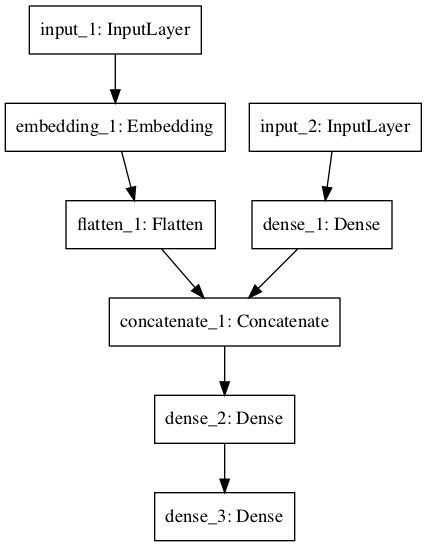

In [5]:
#!pip install pydot
from keras.utils.vis_utils import plot_model  
plot_model(model, to_file='fb_model.png')

from IPython.display import Image
Image(filename='fb_model.png')

In [11]:
batch_size = 128
history = model.fit([padded_docs, Z_train], y_train, epochs=4500, validation_data=([padded_docs_test,X_test],y_test), batch_size=batch_size, verbose=1)

Train on 469 samples, validate on 232 samples
Epoch 1/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 36.8579 - val_mean_absolute_error: 36.8579
Epoch 2/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 36.8297 - val_mean_absolute_error: 36.8297
Epoch 3/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 36.8008 - val_mean_absolute_error: 36.8008
Epoch 4/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 36.7700 - val_mean_absolute_error: 36.7700
Epoch 5/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 36.7422 - val_mean_absolute_error: 36.7422
Epoch 6/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0028 - mean_absolute_error: 0.

Epoch 49/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 35.8023 - val_mean_absolute_error: 35.8023
Epoch 50/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 35.7910 - val_mean_absolute_error: 35.7910
Epoch 51/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 35.7801 - val_mean_absolute_error: 35.7801
Epoch 52/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 35.7670 - val_mean_absolute_error: 35.7670
Epoch 53/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 35.7510 - val_mean_absolute_error: 35.7510
Epoch 54/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0017 - mean_absolute_error: 0.0017 - val_loss: 35.7375 - val_mean_abso

469/469 [==============================] - 0s 20us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.2267 - val_mean_absolute_error: 35.2267
Epoch 98/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.2159 - val_mean_absolute_error: 35.2159
Epoch 99/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.2066 - val_mean_absolute_error: 35.2066
Epoch 100/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.1961 - val_mean_absolute_error: 35.1961
Epoch 101/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.1826 - val_mean_absolute_error: 35.1826
Epoch 102/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 35.1704 - val_mean_absolute_error:

469/469 [==============================] - 0s 20us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6819 - val_mean_absolute_error: 34.6819
Epoch 146/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6704 - val_mean_absolute_error: 34.6704
Epoch 147/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6611 - val_mean_absolute_error: 34.6611
Epoch 148/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6515 - val_mean_absolute_error: 34.6515
Epoch 149/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6427 - val_mean_absolute_error: 34.6427
Epoch 150/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 34.6305 - val_mean_absolute_erro

Epoch 193/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2226 - val_mean_absolute_error: 34.2226
Epoch 194/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2270 - val_mean_absolute_error: 34.2270
Epoch 195/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2319 - val_mean_absolute_error: 34.2319
Epoch 196/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2304 - val_mean_absolute_error: 34.2304
Epoch 197/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2261 - val_mean_absolute_error: 34.2261
Epoch 198/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2185 - val_mea

Epoch 241/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1946 - val_mean_absolute_error: 34.1946
Epoch 242/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1996 - val_mean_absolute_error: 34.1996
Epoch 243/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2064 - val_mean_absolute_error: 34.2064
Epoch 244/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2090 - val_mean_absolute_error: 34.2090
Epoch 245/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2054 - val_mean_absolute_error: 34.2054
Epoch 246/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2015 - val_mea

Epoch 289/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1963 - val_mean_absolute_error: 34.1963
Epoch 290/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2001 - val_mean_absolute_error: 34.2001
Epoch 291/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2009 - val_mean_absolute_error: 34.2009
Epoch 292/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1995 - val_mean_absolute_error: 34.1995
Epoch 293/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1987 - val_mean_absolute_error: 34.1987
Epoch 294/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2028 - val_mea

Epoch 337/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1964 - val_mean_absolute_error: 34.1964
Epoch 338/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1946 - val_mean_absolute_error: 34.1946
Epoch 339/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1974 - val_mean_absolute_error: 34.1974
Epoch 340/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2026 - val_mean_absolute_error: 34.2026
Epoch 341/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2040 - val_mean_absolute_error: 34.2040
Epoch 342/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2001 - val_mea

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1971 - val_mean_absolute_error: 34.1971
Epoch 385/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2008 - val_mean_absolute_error: 34.2008
Epoch 386/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1980 - val_mean_absolute_error: 34.1980
Epoch 387/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1992 - val_mean_absolute_error: 34.1992
Epoch 388/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2008 - val_mean_absolute_error: 34.2008
Epoch 389/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1995 - val_mean_absolute_erro

Epoch 432/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2028 - val_mean_absolute_error: 34.2028
Epoch 433/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2012 - val_mean_absolute_error: 34.2012
Epoch 434/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2021 - val_mean_absolute_error: 34.2021
Epoch 435/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1990 - val_mean_absolute_error: 34.1990
Epoch 436/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1995 - val_mean_absolute_error: 34.1995
Epoch 437/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2032 - val_mea

Epoch 480/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2032 - val_mean_absolute_error: 34.2032
Epoch 481/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2055 - val_mean_absolute_error: 34.2055
Epoch 482/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2032 - val_mean_absolute_error: 34.2032
Epoch 483/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1975 - val_mean_absolute_error: 34.1975
Epoch 484/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1934 - val_mean_absolute_error: 34.1934
Epoch 485/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1934 - val_mea

Epoch 528/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2059 - val_mean_absolute_error: 34.2059
Epoch 529/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1990 - val_mean_absolute_error: 34.1990
Epoch 530/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1953 - val_mean_absolute_error: 34.1953
Epoch 531/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1979 - val_mean_absolute_error: 34.1979
Epoch 532/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2085 - val_mean_absolute_error: 34.2085
Epoch 533/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2097 - val_mea

Epoch 576/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2031 - val_mean_absolute_error: 34.2031
Epoch 577/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2019 - val_mean_absolute_error: 34.2019
Epoch 578/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1980 - val_mean_absolute_error: 34.1980
Epoch 579/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1901 - val_mean_absolute_error: 34.1901
Epoch 580/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1952 - val_mean_absolute_error: 34.1952
Epoch 581/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2042 - val_mea

Epoch 624/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1953 - val_mean_absolute_error: 34.1953
Epoch 625/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1907 - val_mean_absolute_error: 34.1907
Epoch 626/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1949 - val_mean_absolute_error: 34.1949
Epoch 627/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2082 - val_mean_absolute_error: 34.2082
Epoch 628/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2138 - val_mean_absolute_error: 34.2138
Epoch 629/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2077 - val_mea

Epoch 672/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1951 - val_mean_absolute_error: 34.1951
Epoch 673/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1929 - val_mean_absolute_error: 34.1929
Epoch 674/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2040 - val_mean_absolute_error: 34.2040
Epoch 675/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2028 - val_mean_absolute_error: 34.2028
Epoch 676/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1970 - val_mean_absolute_error: 34.1970
Epoch 677/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1936 - val_mea

Epoch 720/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1947 - val_mean_absolute_error: 34.1947
Epoch 721/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2007 - val_mean_absolute_error: 34.2007
Epoch 722/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1984 - val_mean_absolute_error: 34.1984
Epoch 723/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2027 - val_mean_absolute_error: 34.2027
Epoch 724/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2023 - val_mean_absolute_error: 34.2023
Epoch 725/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1988 - val_mea

Epoch 768/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1979 - val_mean_absolute_error: 34.1979
Epoch 769/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1955 - val_mean_absolute_error: 34.1955
Epoch 770/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1991 - val_mean_absolute_error: 34.1991
Epoch 771/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2133 - val_mean_absolute_error: 34.2133
Epoch 772/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2153 - val_mean_absolute_error: 34.2153
Epoch 773/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2071 - val_mea

Epoch 816/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1959 - val_mean_absolute_error: 34.1959
Epoch 817/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2102 - val_mean_absolute_error: 34.2102
Epoch 818/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2130 - val_mean_absolute_error: 34.2130
Epoch 819/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2091 - val_mean_absolute_error: 34.2091
Epoch 820/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1998 - val_mean_absolute_error: 34.1998
Epoch 821/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1848 - val_mea

Epoch 864/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2121 - val_mean_absolute_error: 34.2121
Epoch 865/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2045 - val_mean_absolute_error: 34.2045
Epoch 866/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1879 - val_mean_absolute_error: 34.1879
Epoch 867/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1864 - val_mean_absolute_error: 34.1864
Epoch 868/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1905 - val_mean_absolute_error: 34.1905
Epoch 869/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2069 - val_mea

Epoch 912/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2061 - val_mean_absolute_error: 34.2061
Epoch 913/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1973 - val_mean_absolute_error: 34.1973
Epoch 914/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1996 - val_mean_absolute_error: 34.1996
Epoch 915/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1942 - val_mean_absolute_error: 34.1942
Epoch 916/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1952 - val_mean_absolute_error: 34.1952
Epoch 917/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2086 - val_mea

Epoch 960/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1853 - val_mean_absolute_error: 34.1853
Epoch 961/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1725 - val_mean_absolute_error: 34.1725
Epoch 962/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1846 - val_mean_absolute_error: 34.1846
Epoch 963/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2011 - val_mean_absolute_error: 34.2011
Epoch 964/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2181 - val_mean_absolute_error: 34.2181
Epoch 965/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2016 - val_mea

Epoch 1008/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2005 - val_mean_absolute_error: 34.2005
Epoch 1009/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1933 - val_mean_absolute_error: 34.1933
Epoch 1010/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1957 - val_mean_absolute_error: 34.1957
Epoch 1011/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2092 - val_mean_absolute_error: 34.2092
Epoch 1012/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2054 - val_mean_absolute_error: 34.2054
Epoch 1013/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1910 - v

469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2095 - val_mean_absolute_error: 34.2095
Epoch 1056/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2165 - val_mean_absolute_error: 34.2165
Epoch 1057/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2049 - val_mean_absolute_error: 34.2049
Epoch 1058/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1896 - val_mean_absolute_error: 34.1896
Epoch 1059/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1861 - val_mean_absolute_error: 34.1861
Epoch 1060/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1881 - val_mean_absolute

Epoch 1103/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1886 - val_mean_absolute_error: 34.1886
Epoch 1104/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2042 - val_mean_absolute_error: 34.2042
Epoch 1105/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2085 - val_mean_absolute_error: 34.2085
Epoch 1106/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1908 - val_mean_absolute_error: 34.1908
Epoch 1107/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1902 - val_mean_absolute_error: 34.1902
Epoch 1108/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2040 - v

469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2083 - val_mean_absolute_error: 34.2083
Epoch 1151/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2083 - val_mean_absolute_error: 34.2083
Epoch 1152/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1895 - val_mean_absolute_error: 34.1895
Epoch 1153/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1889 - val_mean_absolute_error: 34.1889
Epoch 1154/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2140 - val_mean_absolute_error: 34.2140
Epoch 1155/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2118 - val_mean_absolute

Epoch 1198/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2168 - val_mean_absolute_error: 34.2168
Epoch 1199/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2029 - val_mean_absolute_error: 34.2029
Epoch 1200/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1646 - val_mean_absolute_error: 34.1646
Epoch 1201/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1521 - val_mean_absolute_error: 34.1521
Epoch 1202/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1683 - val_mean_absolute_error: 34.1683
Epoch 1203/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1832 - v

469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2016 - val_mean_absolute_error: 34.2016
Epoch 1246/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1798 - val_mean_absolute_error: 34.1798
Epoch 1247/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1943 - val_mean_absolute_error: 34.1943
Epoch 1248/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2011 - val_mean_absolute_error: 34.2011
Epoch 1249/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1869 - val_mean_absolute_error: 34.1869
Epoch 1250/4500
469/469 [==============================] - 0s 31us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1854 - val_mean_absolute

Epoch 1293/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1854 - val_mean_absolute_error: 34.1854
Epoch 1294/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1836 - val_mean_absolute_error: 34.1836
Epoch 1295/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1922 - val_mean_absolute_error: 34.1922
Epoch 1296/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1900 - val_mean_absolute_error: 34.1900
Epoch 1297/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1903 - val_mean_absolute_error: 34.1903
Epoch 1298/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2027 - v

469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1549 - val_mean_absolute_error: 34.1549
Epoch 1341/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1702 - val_mean_absolute_error: 34.1702
Epoch 1342/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2053 - val_mean_absolute_error: 34.2053
Epoch 1343/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2122 - val_mean_absolute_error: 34.2122
Epoch 1344/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2114 - val_mean_absolute_error: 34.2114
Epoch 1345/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1789 - val_mean_absolute

Epoch 1388/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2223 - val_mean_absolute_error: 34.2223
Epoch 1389/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2029 - val_mean_absolute_error: 34.2029
Epoch 1390/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1767 - val_mean_absolute_error: 34.1767
Epoch 1391/4500
469/469 [==============================] - 0s 34us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1624 - val_mean_absolute_error: 34.1624
Epoch 1392/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1641 - val_mean_absolute_error: 34.1641
Epoch 1393/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1897 - v

469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2008 - val_mean_absolute_error: 34.2008
Epoch 1436/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1811 - val_mean_absolute_error: 34.1811
Epoch 1437/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1751 - val_mean_absolute_error: 34.1751
Epoch 1438/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1918 - val_mean_absolute_error: 34.1918
Epoch 1439/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2047 - val_mean_absolute_error: 34.2047
Epoch 1440/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1846 - val_mean_absolute

Epoch 1483/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1790 - val_mean_absolute_error: 34.1790
Epoch 1484/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1549 - val_mean_absolute_error: 34.1549
Epoch 1485/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1605 - val_mean_absolute_error: 34.1605
Epoch 1486/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1864 - val_mean_absolute_error: 34.1864
Epoch 1487/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2317 - val_mean_absolute_error: 34.2317
Epoch 1488/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2351 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2083 - val_mean_absolute_error: 34.2083
Epoch 1531/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1864 - val_mean_absolute_error: 34.1864
Epoch 1532/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1795 - val_mean_absolute_error: 34.1795
Epoch 1533/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1824 - val_mean_absolute_error: 34.1824
Epoch 1534/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2171 - val_mean_absolute_error: 34.2171
Epoch 1535/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2286 - val_mean_absolute

Epoch 1578/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1681 - val_mean_absolute_error: 34.1681
Epoch 1579/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1916 - val_mean_absolute_error: 34.1916
Epoch 1580/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1907 - val_mean_absolute_error: 34.1907
Epoch 1581/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1854 - val_mean_absolute_error: 34.1854
Epoch 1582/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1958 - val_mean_absolute_error: 34.1958
Epoch 1583/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1886 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1698 - val_mean_absolute_error: 34.1698
Epoch 1626/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2093 - val_mean_absolute_error: 34.2093
Epoch 1627/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2084 - val_mean_absolute_error: 34.2084
Epoch 1628/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1892 - val_mean_absolute_error: 34.1892
Epoch 1629/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1741 - val_mean_absolute_error: 34.1741
Epoch 1630/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1729 - val_mean_absolute

Epoch 1673/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1390 - val_mean_absolute_error: 34.1390
Epoch 1674/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1526 - val_mean_absolute_error: 34.1526
Epoch 1675/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1728 - val_mean_absolute_error: 34.1728
Epoch 1676/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2117 - val_mean_absolute_error: 34.2117
Epoch 1677/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2307 - val_mean_absolute_error: 34.2307
Epoch 1678/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2044 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1564 - val_mean_absolute_error: 34.1564
Epoch 1721/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1531 - val_mean_absolute_error: 34.1531
Epoch 1722/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1823 - val_mean_absolute_error: 34.1823
Epoch 1723/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1927 - val_mean_absolute_error: 34.1927
Epoch 1724/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1590 - val_mean_absolute_error: 34.1590
Epoch 1725/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1430 - val_mean_absolute

Epoch 1768/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1917 - val_mean_absolute_error: 34.1917
Epoch 1769/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1840 - val_mean_absolute_error: 34.1840
Epoch 1770/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1704 - val_mean_absolute_error: 34.1704
Epoch 1771/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1709 - val_mean_absolute_error: 34.1709
Epoch 1772/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1724 - val_mean_absolute_error: 34.1724
Epoch 1773/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1711 - v

469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1766 - val_mean_absolute_error: 34.1766
Epoch 1816/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1864 - val_mean_absolute_error: 34.1864
Epoch 1817/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1855 - val_mean_absolute_error: 34.1855
Epoch 1818/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1614 - val_mean_absolute_error: 34.1614
Epoch 1819/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1532 - val_mean_absolute_error: 34.1532
Epoch 1820/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1558 - val_mean_absolute

Epoch 1863/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1788 - val_mean_absolute_error: 34.1788
Epoch 1864/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1675 - val_mean_absolute_error: 34.1675
Epoch 1865/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1481 - val_mean_absolute_error: 34.1481
Epoch 1866/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1796 - val_mean_absolute_error: 34.1796
Epoch 1867/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1863 - val_mean_absolute_error: 34.1863
Epoch 1868/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1428 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1489 - val_mean_absolute_error: 34.1489
Epoch 1911/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1929 - val_mean_absolute_error: 34.1929
Epoch 1912/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2106 - val_mean_absolute_error: 34.2106
Epoch 1913/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1799 - val_mean_absolute_error: 34.1799
Epoch 1914/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1540 - val_mean_absolute_error: 34.1540
Epoch 1915/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1455 - val_mean_absolute

Epoch 1958/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1867 - val_mean_absolute_error: 34.1867
Epoch 1959/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1591 - val_mean_absolute_error: 34.1591
Epoch 1960/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1485 - val_mean_absolute_error: 34.1485
Epoch 1961/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1718 - val_mean_absolute_error: 34.1718
Epoch 1962/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1655 - val_mean_absolute_error: 34.1655
Epoch 1963/4500
469/469 [==============================] - 0s 36us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1589 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1553 - val_mean_absolute_error: 34.1553
Epoch 2006/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1761 - val_mean_absolute_error: 34.1761
Epoch 2007/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1881 - val_mean_absolute_error: 34.1881
Epoch 2008/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1566 - val_mean_absolute_error: 34.1566
Epoch 2009/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1285 - val_mean_absolute_error: 34.1285
Epoch 2010/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1363 - val_mean_absolute

Epoch 2053/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.2112 - val_mean_absolute_error: 34.2112
Epoch 2054/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1816 - val_mean_absolute_error: 34.1816
Epoch 2055/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1512 - val_mean_absolute_error: 34.1512
Epoch 2056/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1363 - val_mean_absolute_error: 34.1363
Epoch 2057/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1501 - val_mean_absolute_error: 34.1501
Epoch 2058/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1820 - v

469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1910 - val_mean_absolute_error: 34.1910
Epoch 2101/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1587 - val_mean_absolute_error: 34.1587
Epoch 2102/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1384 - val_mean_absolute_error: 34.1384
Epoch 2103/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1525 - val_mean_absolute_error: 34.1525
Epoch 2104/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1729 - val_mean_absolute_error: 34.1729
Epoch 2105/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1429 - val_mean_absolute

Epoch 2148/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1571 - val_mean_absolute_error: 34.1571
Epoch 2149/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1436 - val_mean_absolute_error: 34.1436
Epoch 2150/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1700 - val_mean_absolute_error: 34.1700
Epoch 2151/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1744 - val_mean_absolute_error: 34.1744
Epoch 2152/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1454 - val_mean_absolute_error: 34.1454
Epoch 2153/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1465 - v

469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1258 - val_mean_absolute_error: 34.1258
Epoch 2196/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1185 - val_mean_absolute_error: 34.1185
Epoch 2197/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1305 - val_mean_absolute_error: 34.1305
Epoch 2198/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1751 - val_mean_absolute_error: 34.1751
Epoch 2199/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1935 - val_mean_absolute_error: 34.1935
Epoch 2200/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1755 - val_mean_absolute

Epoch 2243/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1856 - val_mean_absolute_error: 34.1856
Epoch 2244/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1750 - val_mean_absolute_error: 34.1750
Epoch 2245/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1452 - val_mean_absolute_error: 34.1452
Epoch 2246/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1005 - val_mean_absolute_error: 34.1005
Epoch 2247/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0876 - val_mean_absolute_error: 34.0876
Epoch 2248/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1023 - v

469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1208 - val_mean_absolute_error: 34.1208
Epoch 2291/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1397 - val_mean_absolute_error: 34.1397
Epoch 2292/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1522 - val_mean_absolute_error: 34.1522
Epoch 2293/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1320 - val_mean_absolute_error: 34.1320
Epoch 2294/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1132 - val_mean_absolute_error: 34.1132
Epoch 2295/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1327 - val_mean_absolute

Epoch 2338/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1367 - val_mean_absolute_error: 34.1367
Epoch 2339/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1171 - val_mean_absolute_error: 34.1171
Epoch 2340/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1297 - val_mean_absolute_error: 34.1297
Epoch 2341/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1359 - val_mean_absolute_error: 34.1359
Epoch 2342/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1310 - val_mean_absolute_error: 34.1310
Epoch 2343/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1364 - v

469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1521 - val_mean_absolute_error: 34.1521
Epoch 2386/4500
469/469 [==============================] - 0s 31us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1715 - val_mean_absolute_error: 34.1715
Epoch 2387/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1508 - val_mean_absolute_error: 34.1508
Epoch 2388/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1155 - val_mean_absolute_error: 34.1155
Epoch 2389/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0959 - val_mean_absolute_error: 34.0959
Epoch 2390/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1144 - val_mean_absolute

Epoch 2433/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1566 - val_mean_absolute_error: 34.1566
Epoch 2434/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1683 - val_mean_absolute_error: 34.1683
Epoch 2435/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1678 - val_mean_absolute_error: 34.1678
Epoch 2436/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1301 - val_mean_absolute_error: 34.1301
Epoch 2437/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1203 - val_mean_absolute_error: 34.1203
Epoch 2438/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1143 - v

469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1787 - val_mean_absolute_error: 34.1787
Epoch 2481/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1481 - val_mean_absolute_error: 34.1481
Epoch 2482/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1059 - val_mean_absolute_error: 34.1059
Epoch 2483/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0972 - val_mean_absolute_error: 34.0972
Epoch 2484/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1094 - val_mean_absolute_error: 34.1094
Epoch 2485/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1216 - val_mean_absolute

Epoch 2528/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1088 - val_mean_absolute_error: 34.1088
Epoch 2529/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1008 - val_mean_absolute_error: 34.1008
Epoch 2530/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1153 - val_mean_absolute_error: 34.1153
Epoch 2531/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1257 - val_mean_absolute_error: 34.1257
Epoch 2532/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1175 - val_mean_absolute_error: 34.1175
Epoch 2533/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0808 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1142 - val_mean_absolute_error: 34.1142
Epoch 2576/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1035 - val_mean_absolute_error: 34.1035
Epoch 2577/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0707 - val_mean_absolute_error: 34.0707
Epoch 2578/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0725 - val_mean_absolute_error: 34.0725
Epoch 2579/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0934 - val_mean_absolute_error: 34.0934
Epoch 2580/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0939 - val_mean_absolute

Epoch 2623/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1200 - val_mean_absolute_error: 34.1200
Epoch 2624/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1307 - val_mean_absolute_error: 34.1307
Epoch 2625/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1164 - val_mean_absolute_error: 34.1164
Epoch 2626/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0756 - val_mean_absolute_error: 34.0756
Epoch 2627/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0668 - val_mean_absolute_error: 34.0668
Epoch 2628/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0705 - v

469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0908 - val_mean_absolute_error: 34.0908
Epoch 2671/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1106 - val_mean_absolute_error: 34.1106
Epoch 2672/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0850 - val_mean_absolute_error: 34.0850
Epoch 2673/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0834 - val_mean_absolute_error: 34.0834
Epoch 2674/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0964 - val_mean_absolute_error: 34.0964
Epoch 2675/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0809 - val_mean_absolute

Epoch 2718/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0945 - val_mean_absolute_error: 34.0945
Epoch 2719/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0705 - val_mean_absolute_error: 34.0705
Epoch 2720/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0710 - val_mean_absolute_error: 34.0710
Epoch 2721/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0847 - val_mean_absolute_error: 34.0847
Epoch 2722/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.1087 - val_mean_absolute_error: 34.1087
Epoch 2723/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0816 - v

469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0435 - val_mean_absolute_error: 34.0435
Epoch 2766/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0454 - val_mean_absolute_error: 34.0454
Epoch 2767/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0634 - val_mean_absolute_error: 34.0634
Epoch 2768/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0643 - val_mean_absolute_error: 34.0643
Epoch 2769/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0321 - val_mean_absolute_error: 34.0321
Epoch 2770/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0346 - val_mean_absolute

Epoch 2813/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0420 - val_mean_absolute_error: 34.0420
Epoch 2814/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0697 - val_mean_absolute_error: 34.0697
Epoch 2815/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0778 - val_mean_absolute_error: 34.0778
Epoch 2816/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0547 - val_mean_absolute_error: 34.0547
Epoch 2817/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9900 - val_mean_absolute_error: 33.9900
Epoch 2818/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9754 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0293 - val_mean_absolute_error: 34.0293
Epoch 2861/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0451 - val_mean_absolute_error: 34.0451
Epoch 2862/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0537 - val_mean_absolute_error: 34.0537
Epoch 2863/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0061 - val_mean_absolute_error: 34.0061
Epoch 2864/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9956 - val_mean_absolute_error: 33.9956
Epoch 2865/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0077 - val_mean_absolute

Epoch 2908/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0160 - val_mean_absolute_error: 34.0160
Epoch 2909/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0225 - val_mean_absolute_error: 34.0225
Epoch 2910/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0151 - val_mean_absolute_error: 34.0151
Epoch 2911/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0523 - val_mean_absolute_error: 34.0523
Epoch 2912/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0613 - val_mean_absolute_error: 34.0613
Epoch 2913/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0498 - v

469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9171 - val_mean_absolute_error: 33.9171
Epoch 2956/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9272 - val_mean_absolute_error: 33.9272
Epoch 2957/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9618 - val_mean_absolute_error: 33.9618
Epoch 2958/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0040 - val_mean_absolute_error: 34.0040
Epoch 2959/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0241 - val_mean_absolute_error: 34.0241
Epoch 2960/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9788 - val_mean_absolute

Epoch 3003/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0010 - val_mean_absolute_error: 34.0010
Epoch 3004/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0329 - val_mean_absolute_error: 34.0329
Epoch 3005/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0171 - val_mean_absolute_error: 34.0171
Epoch 3006/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9515 - val_mean_absolute_error: 33.9515
Epoch 3007/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9258 - val_mean_absolute_error: 33.9258
Epoch 3008/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9355 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0094 - val_mean_absolute_error: 34.0094
Epoch 3051/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 34.0200 - val_mean_absolute_error: 34.0200
Epoch 3052/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9963 - val_mean_absolute_error: 33.9963
Epoch 3053/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9587 - val_mean_absolute_error: 33.9587
Epoch 3054/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9491 - val_mean_absolute_error: 33.9491
Epoch 3055/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9789 - val_mean_absolute

Epoch 3098/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9128 - val_mean_absolute_error: 33.9128
Epoch 3099/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9256 - val_mean_absolute_error: 33.9256
Epoch 3100/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9671 - val_mean_absolute_error: 33.9671
Epoch 3101/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9861 - val_mean_absolute_error: 33.9861
Epoch 3102/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9512 - val_mean_absolute_error: 33.9512
Epoch 3103/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9362 - v

469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9676 - val_mean_absolute_error: 33.9676
Epoch 3146/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9463 - val_mean_absolute_error: 33.9463
Epoch 3147/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9241 - val_mean_absolute_error: 33.9241
Epoch 3148/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9087 - val_mean_absolute_error: 33.9087
Epoch 3149/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9228 - val_mean_absolute_error: 33.9228
Epoch 3150/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9365 - val_mean_absolute

Epoch 3193/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9060 - val_mean_absolute_error: 33.9060
Epoch 3194/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9008 - val_mean_absolute_error: 33.9008
Epoch 3195/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9196 - val_mean_absolute_error: 33.9196
Epoch 3196/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9071 - val_mean_absolute_error: 33.9071
Epoch 3197/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9046 - val_mean_absolute_error: 33.9046
Epoch 3198/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9172 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8712 - val_mean_absolute_error: 33.8712
Epoch 3241/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9177 - val_mean_absolute_error: 33.9177
Epoch 3242/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9368 - val_mean_absolute_error: 33.9368
Epoch 3243/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.9135 - val_mean_absolute_error: 33.9135
Epoch 3244/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8691 - val_mean_absolute_error: 33.8691
Epoch 3245/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8613 - val_mean_absolute

Epoch 3288/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8474 - val_mean_absolute_error: 33.8474
Epoch 3289/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8701 - val_mean_absolute_error: 33.8701
Epoch 3290/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8805 - val_mean_absolute_error: 33.8805
Epoch 3291/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8525 - val_mean_absolute_error: 33.8525
Epoch 3292/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8452 - val_mean_absolute_error: 33.8452
Epoch 3293/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8655 - v

469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8452 - val_mean_absolute_error: 33.8452
Epoch 3336/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8266 - val_mean_absolute_error: 33.8266
Epoch 3337/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8307 - val_mean_absolute_error: 33.8307
Epoch 3338/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8487 - val_mean_absolute_error: 33.8487
Epoch 3339/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8436 - val_mean_absolute_error: 33.8436
Epoch 3340/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8067 - val_mean_absolute

Epoch 3383/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7850 - val_mean_absolute_error: 33.7850
Epoch 3384/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8322 - val_mean_absolute_error: 33.8322
Epoch 3385/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8485 - val_mean_absolute_error: 33.8485
Epoch 3386/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8304 - val_mean_absolute_error: 33.8304
Epoch 3387/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7855 - val_mean_absolute_error: 33.7855
Epoch 3388/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7743 - v

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7553 - val_mean_absolute_error: 33.7553
Epoch 3431/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7565 - val_mean_absolute_error: 33.7565
Epoch 3432/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7616 - val_mean_absolute_error: 33.7616
Epoch 3433/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7740 - val_mean_absolute_error: 33.7740
Epoch 3434/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7789 - val_mean_absolute_error: 33.7789
Epoch 3435/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.8047 - val_mean_absolute

Epoch 3478/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7387 - val_mean_absolute_error: 33.7387
Epoch 3479/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7167 - val_mean_absolute_error: 33.7167
Epoch 3480/4500
469/469 [==============================] - 0s 26us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7004 - val_mean_absolute_error: 33.7004
Epoch 3481/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7198 - val_mean_absolute_error: 33.7198
Epoch 3482/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7613 - val_mean_absolute_error: 33.7613
Epoch 3483/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7730 - v

469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7227 - val_mean_absolute_error: 33.7227
Epoch 3526/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7337 - val_mean_absolute_error: 33.7337
Epoch 3527/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6946 - val_mean_absolute_error: 33.6946
Epoch 3528/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6691 - val_mean_absolute_error: 33.6691
Epoch 3529/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6785 - val_mean_absolute_error: 33.6785
Epoch 3530/4500
469/469 [==============================] - 0s 24us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.7181 - val_mean_absolute

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6948 - val_mean_absolute_error: 33.6948
Epoch 3573/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6692 - val_mean_absolute_error: 33.6692
Epoch 3574/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6661 - val_mean_absolute_error: 33.6661
Epoch 3575/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6947 - val_mean_absolute_error: 33.6947
Epoch 3576/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6944 - val_mean_absolute_error: 33.6944
Epoch 3577/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6632 - val_mean_absolute

Epoch 3620/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6739 - val_mean_absolute_error: 33.6739
Epoch 3621/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6207 - val_mean_absolute_error: 33.6207
Epoch 3622/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5810 - val_mean_absolute_error: 33.5810
Epoch 3623/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5769 - val_mean_absolute_error: 33.5769
Epoch 3624/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6052 - val_mean_absolute_error: 33.6052
Epoch 3625/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6493 - v

469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6078 - val_mean_absolute_error: 33.6078
Epoch 3668/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5964 - val_mean_absolute_error: 33.5964
Epoch 3669/4500
469/469 [==============================] - 0s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.6040 - val_mean_absolute_error: 33.6040
Epoch 3670/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5950 - val_mean_absolute_error: 33.5950
Epoch 3671/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5582 - val_mean_absolute_error: 33.5582
Epoch 3672/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5599 - val_mean_absolute

469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5674 - val_mean_absolute_error: 33.5674
Epoch 3715/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5487 - val_mean_absolute_error: 33.5487
Epoch 3716/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5547 - val_mean_absolute_error: 33.5547
Epoch 3717/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5689 - val_mean_absolute_error: 33.5689
Epoch 3718/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5521 - val_mean_absolute_error: 33.5521
Epoch 3719/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5572 - val_mean_absolute

Epoch 3762/4500
469/469 [==============================] - 0s 27us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4969 - val_mean_absolute_error: 33.4969
Epoch 3763/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4816 - val_mean_absolute_error: 33.4816
Epoch 3764/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5030 - val_mean_absolute_error: 33.5030
Epoch 3765/4500
469/469 [==============================] - 0s 28us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5105 - val_mean_absolute_error: 33.5105
Epoch 3766/4500
469/469 [==============================] - 0s 29us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5244 - val_mean_absolute_error: 33.5244
Epoch 3767/4500
469/469 [==============================] - 0s 30us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.5037 - v

469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4733 - val_mean_absolute_error: 33.4733
Epoch 3810/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4810 - val_mean_absolute_error: 33.4810
Epoch 3811/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4577 - val_mean_absolute_error: 33.4577
Epoch 3812/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4597 - val_mean_absolute_error: 33.4597
Epoch 3813/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4759 - val_mean_absolute_error: 33.4759
Epoch 3814/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4819 - val_mean_absolute

Epoch 3857/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3905 - val_mean_absolute_error: 33.3905
Epoch 3858/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4085 - val_mean_absolute_error: 33.4085
Epoch 3859/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4212 - val_mean_absolute_error: 33.4212
Epoch 3860/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.4183 - val_mean_absolute_error: 33.4183
Epoch 3861/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3929 - val_mean_absolute_error: 33.3929
Epoch 3862/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3848 - v

469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3797 - val_mean_absolute_error: 33.3797
Epoch 3905/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3613 - val_mean_absolute_error: 33.3613
Epoch 3906/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3438 - val_mean_absolute_error: 33.3438
Epoch 3907/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3726 - val_mean_absolute_error: 33.3726
Epoch 3908/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3735 - val_mean_absolute_error: 33.3735
Epoch 3909/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3404 - val_mean_absolute

Epoch 3952/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2822 - val_mean_absolute_error: 33.2822
Epoch 3953/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3085 - val_mean_absolute_error: 33.3085
Epoch 3954/4500
469/469 [==============================] - 0s 23us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3367 - val_mean_absolute_error: 33.3367
Epoch 3955/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3234 - val_mean_absolute_error: 33.3234
Epoch 3956/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3076 - val_mean_absolute_error: 33.3076
Epoch 3957/4500
469/469 [==============================] - 0s 22us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.3015 - v

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2547 - val_mean_absolute_error: 33.2547
Epoch 4000/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2536 - val_mean_absolute_error: 33.2536
Epoch 4001/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2637 - val_mean_absolute_error: 33.2637
Epoch 4002/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2539 - val_mean_absolute_error: 33.2539
Epoch 4003/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2236 - val_mean_absolute_error: 33.2236
Epoch 4004/4500
469/469 [==============================] - 0s 16us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2136 - val_mean_absolute

Epoch 4047/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2265 - val_mean_absolute_error: 33.2265
Epoch 4048/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2259 - val_mean_absolute_error: 33.2259
Epoch 4049/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1906 - val_mean_absolute_error: 33.1906
Epoch 4050/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1868 - val_mean_absolute_error: 33.1868
Epoch 4051/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2064 - val_mean_absolute_error: 33.2064
Epoch 4052/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.2197 - v

469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1554 - val_mean_absolute_error: 33.1554
Epoch 4095/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1285 - val_mean_absolute_error: 33.1285
Epoch 4096/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1312 - val_mean_absolute_error: 33.1312
Epoch 4097/4500
469/469 [==============================] - 0s 16us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1408 - val_mean_absolute_error: 33.1408
Epoch 4098/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1457 - val_mean_absolute_error: 33.1457
Epoch 4099/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1247 - val_mean_absolute

Epoch 4142/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0854 - val_mean_absolute_error: 33.0854
Epoch 4143/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.1098 - val_mean_absolute_error: 33.1098
Epoch 4144/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0811 - val_mean_absolute_error: 33.0811
Epoch 4145/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0705 - val_mean_absolute_error: 33.0705
Epoch 4146/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0921 - val_mean_absolute_error: 33.0921
Epoch 4147/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0913 - v

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0523 - val_mean_absolute_error: 33.0523
Epoch 4190/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0288 - val_mean_absolute_error: 33.0288
Epoch 4191/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0229 - val_mean_absolute_error: 33.0229
Epoch 4192/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0600 - val_mean_absolute_error: 33.0600
Epoch 4193/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0556 - val_mean_absolute_error: 33.0556
Epoch 4194/4500
469/469 [==============================] - 0s 20us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0242 - val_mean_absolute

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9843 - val_mean_absolute_error: 32.9843
Epoch 4237/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9939 - val_mean_absolute_error: 32.9939
Epoch 4238/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9699 - val_mean_absolute_error: 32.9699
Epoch 4239/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9798 - val_mean_absolute_error: 32.9798
Epoch 4240/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9981 - val_mean_absolute_error: 32.9981
Epoch 4241/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 33.0073 - val_mean_absolute

Epoch 4284/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9662 - val_mean_absolute_error: 32.9662
Epoch 4285/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9431 - val_mean_absolute_error: 32.9431
Epoch 4286/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8801 - val_mean_absolute_error: 32.8801
Epoch 4287/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8607 - val_mean_absolute_error: 32.8607
Epoch 4288/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8824 - val_mean_absolute_error: 32.8824
Epoch 4289/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9151 - v

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9147 - val_mean_absolute_error: 32.9147
Epoch 4332/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9206 - val_mean_absolute_error: 32.9206
Epoch 4333/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.9012 - val_mean_absolute_error: 32.9012
Epoch 4334/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8800 - val_mean_absolute_error: 32.8800
Epoch 4335/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8663 - val_mean_absolute_error: 32.8663
Epoch 4336/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8851 - val_mean_absolute

Epoch 4379/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8450 - val_mean_absolute_error: 32.8450
Epoch 4380/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8480 - val_mean_absolute_error: 32.8480
Epoch 4381/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8518 - val_mean_absolute_error: 32.8518
Epoch 4382/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8510 - val_mean_absolute_error: 32.8510
Epoch 4383/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8206 - val_mean_absolute_error: 32.8206
Epoch 4384/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8234 - v

469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8130 - val_mean_absolute_error: 32.8130
Epoch 4427/4500
469/469 [==============================] - 0s 21us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7859 - val_mean_absolute_error: 32.7859
Epoch 4428/4500
469/469 [==============================] - 0s 19us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7670 - val_mean_absolute_error: 32.7670
Epoch 4429/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7990 - val_mean_absolute_error: 32.7990
Epoch 4430/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.8082 - val_mean_absolute_error: 32.8082
Epoch 4431/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7867 - val_mean_absolute

Epoch 4474/4500
469/469 [==============================] - 0s 16us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7462 - val_mean_absolute_error: 32.7462
Epoch 4475/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7239 - val_mean_absolute_error: 32.7239
Epoch 4476/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7149 - val_mean_absolute_error: 32.7149
Epoch 4477/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7334 - val_mean_absolute_error: 32.7334
Epoch 4478/4500
469/469 [==============================] - 0s 18us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7660 - val_mean_absolute_error: 32.7660
Epoch 4479/4500
469/469 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0011 - val_loss: 32.7816 - v

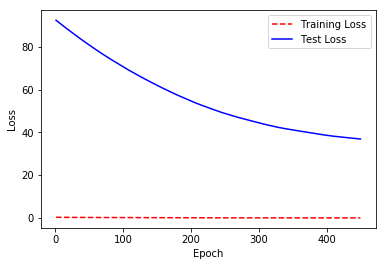

In [7]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [8]:
model_class.save_model(model, 'FB-Model-01')

Saved model to disk


/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:126: ResourceWarning: unclosed file <_io.BufferedWriter name='FB-Model-01-scaler.pkl'>
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:127: ResourceWarning: unclosed file <_io.BufferedWriter name='FB-Model-01-encoders.pkl'>


In [9]:
url = 'posts-predict.json'
df_predict = pd.read_json(url, orient='columns')

model_class = FBModel()
model_class.preprocess(df_predict)

y_pred = model_class.predict(df_predict,'FB-Model-01')
print(df_predict['shares'].values)
print(y_pred)

[21  3]
[[0.00044967]
 [0.00044967]]


/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:139: ResourceWarning: unclosed file <_io.BufferedReader name='FB-Model-01-scaler.pkl'>
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:140: ResourceWarning: unclosed file <_io.BufferedReader name='FB-Model-01-encoders.pkl'>
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:159: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [10]:
#END